First we collect the data from a weather station e.g. Bremerhaven (701) from DWD Weather data portal. The inputs are start and end time and we get the wind speed and wind direction at one height only.

In [234]:
# import packages into compiler
from datetime import datetime, timezone, timedelta
import pandas as pd
from wetterdienst import Wetterdienst, Resolution, Period
from wetterdienst.provider.dwd.observation import DwdObservationRequest, DwdObservationDataset
import datetime as dt
API = Wetterdienst("dwd","observation")
observations_meta = API.discover(filter_=Resolution.HOURLY ,flatten=False)

# define the start and end time, the period is recent which means it is limited to a certain timeframe refer to the DWD data portal for further details
tstart = datetime.strptime('2022-11-01_00-00-00', '%Y-%m-%d_%H-%M-%S') # Select start date in the form yyyy-mm-dd_HH-MM-SS
# funktioniert
tend = tstart + timedelta(days=365) # Select start date in the form yyyy-mm-dd_HH-MM-SS
pdData = pd.DataFrame()
request = DwdObservationRequest(
    parameter=[
        "wind_speed",
        "wind_direction", 
        ],
    resolution = "minute_10", # 10-minute averages
    period="recent", # can be changed to historical as well, see 
    start_date= (tstart + dt.timedelta(minutes = 10)).strftime("%Y-%m-%d %H:%M"),
    end_date = tend.strftime("%Y-%m-%d %H:%M"),
    # tidy=False,
    # humanize=False,
    # si_units=True,
    ).filter_by_station_id(station_id=(701))

station_data = request.values.all().df
new_df = station_data.groupby(station_data['parameter'], observed=True)
param = station_data.parameter.unique()
param_abbr = [
    'ws', 
    'wd', 
    ]
for i in range(len(param)):
    pdData['dwd_' + param_abbr[i]] = station_data.value[station_data.parameter== param[i]].values

pdData.index = pd.date_range(tstart, tend, freq='10T', tz = 'UTC', inclusive='right')
pdData.index.name = "Timestamp"

start_date and end_date filtering limited to defined periods [<Period.RECENT: 'recent'>]
c:\Users\giyash\AppData\Local\miniconda3\envs\py39\lib\site-packages\wetterdienst\provider\dwd\observation\api.py:626: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  stations_df = stations_df.append(df)
c:\Users\giyash\AppData\Local\miniconda3\envs\py39\lib\site-packages\wetterdienst\provider\dwd\observation\api.py:213: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  parameter_df = parameter_df.append(period_df)
c:\Users\giyash\AppData\Local\miniconda3\envs\py39\lib\site-packages\wetterdienst\provider\dwd\observation\api.py:213: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  parameter_df = parameter_df.append(period_df)


In [235]:
print(pdData.head())

print(pdData.describe().T)


                           dwd_ws  dwd_wd
Timestamp                                
2022-11-01 00:10:00+00:00     5.5   120.0
2022-11-01 00:20:00+00:00     6.1   120.0
2022-11-01 00:30:00+00:00     6.0   130.0
2022-11-01 00:40:00+00:00     5.9   120.0
2022-11-01 00:50:00+00:00     5.1   120.0
          count        mean        std   min    25%    50%    75%    max
dwd_ws  51488.0    5.276688   2.835784   0.1    3.2    4.7    6.8   20.3
dwd_wd  51488.0  190.424565  89.996139  10.0  120.0  200.0  250.0  360.0


Plotting the wind speed and wind direction time series, we get

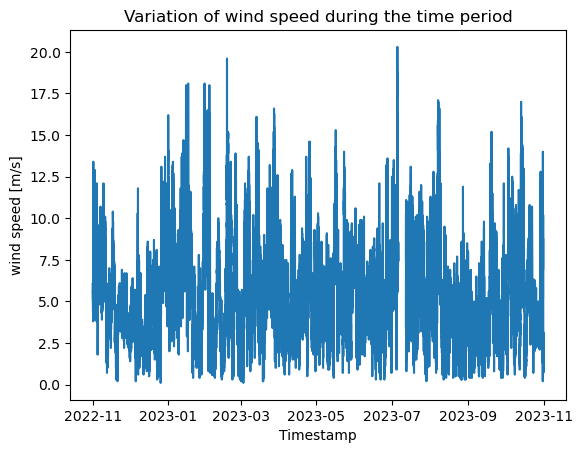

In [236]:
import matplotlib.pyplot as plt
plt.plot(pdData.index, pdData.dwd_ws, label='windspeed')
plt.title("Variation of wind speed during the time period")
plt.xlabel("Timestamp")
plt.ylabel("wind speed [m/s]")
plt.show()


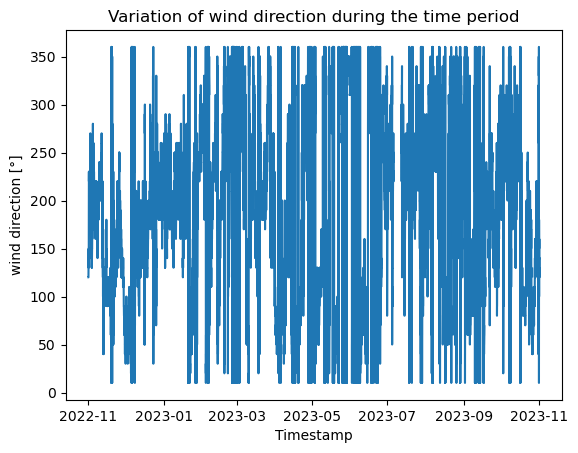

In [237]:
import matplotlib.pyplot as plt
plt.plot(pdData.index, pdData.dwd_wd, label='windspeed')
plt.title("Variation of wind direction during the time period")
plt.xlabel("Timestamp")
plt.ylabel("wind direction [°]")
plt.show()


Now we try to have a look at the distribution of the wind speed and wind direction that is shown using the data. The distributions show how often a wind speed belonging to a certain bin (e.g. 5 - 5.5 m/s) has occured. You can explore more plots using the seaborn library using this link https://seaborn.pydata.org/tutorial/distributions.html

Text(0.5, 1.0, 'Distribution of wind for bin width = 0.5 m/s')

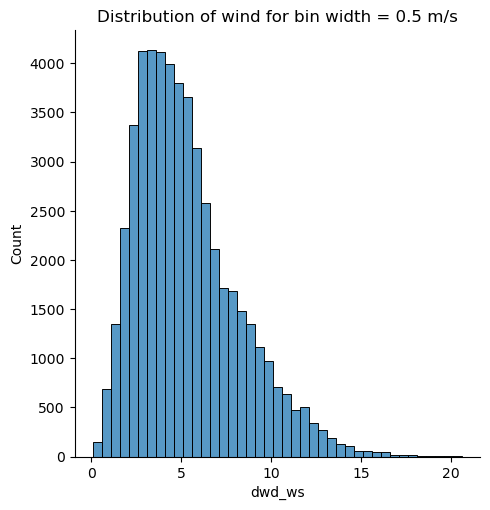

In [238]:
import seaborn as sns
sns.displot(pdData, x="dwd_ws", binwidth=0.5)
plt.title("Distribution of wind for bin width = 0.5 m/s")

Text(0.5, 1.0, 'Distribution of wind speed with a kde-fitted line')

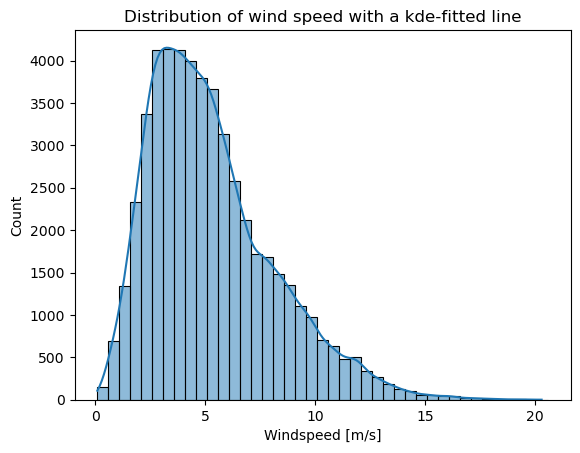

In [239]:
sns.histplot(pdData.dwd_ws, kde=True, binwidth=0.5)
plt.xlabel("Windspeed [m/s]")
plt.title("Distribution of wind speed with a kde-fitted line")

Text(0, 0.5, 'Count')

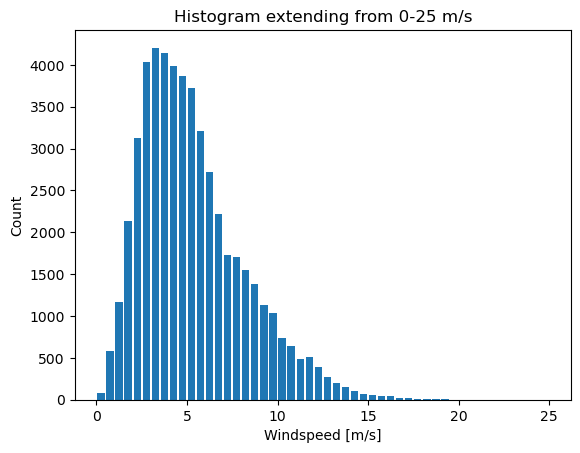

In [240]:
vals, bins, hist = plt.hist(pdData.dwd_ws, bins=50,range=[0, 25], rwidth=0.8)
bin_center = (bins[:-1] + bins[1:]) / 2
plt.title("Histogram extending from 0-25 m/s")
plt.xlabel("Windspeed [m/s]")
plt.ylabel("Count")


If you want to get the Weibull parameters from the data. The shape parameter of k=2 represents a special case of Rayleigh distribution, known as the Weibull distribution. One can use these parameters directly to estimate the annual enery yield of a wind turbine.

In [241]:
from scipy import stats
a_out, k_out, loc_out, A_out = stats.exponweib.fit(pdData.dwd_ws.bfill().ffill(),floc=0,f0=1)
print(f"Scale A: {A_out}")
print(f"Shape k: {k_out}")

Scale A: 6.026570413301208
Shape k: 1.9943069975994896


Text(0.5, 1.0, 'Histogram of wind direction with East = 0°')

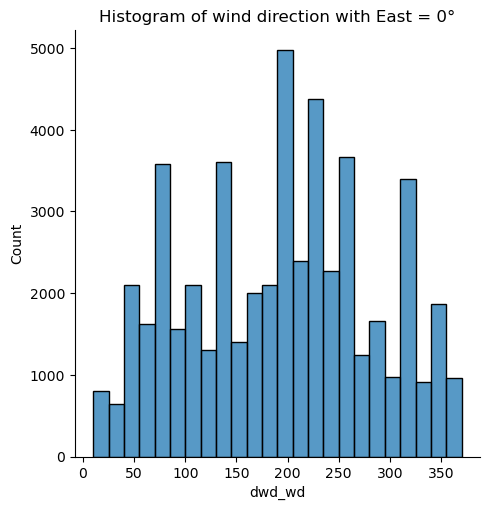

In [245]:
sns.displot(pdData, x="dwd_wd", binwidth=15)
plt.title("Histogram of wind direction with East = 0°")

The wind direction distribution is a bit confusing if shown as a bar plot. A polar plot suits the wind direction better. This can be shown well using the windrose library. The counts here are normalized using the total number of points, such that they represent percentage counts.

[Text(0.5, 1.0, 'wind direction with wind speed')]

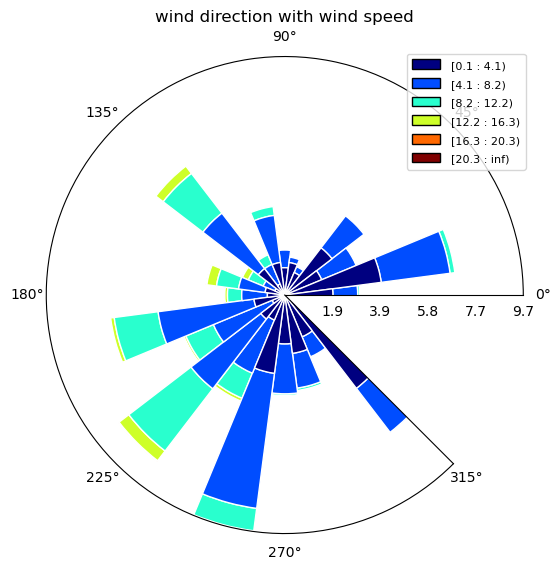

In [246]:
from windrose import WindroseAxes

fig = plt.figure(figsize=(8,6))
ax=WindroseAxes.from_ax(fig=fig)
ax.bar(pdData.dwd_wd, pdData.dwd_ws, normed=True, opening=1, edgecolor='white', nsector=24)
ax.set_legend(loc='best')
ax.set(title='wind direction with wind speed')

Vertical extrapolation:

The vertical extrapolation of the wind speeds is performed to extrapolate the wind speed from the measured height (traditionally 10 m). A wind shear profile is required for this purpose and is dependent on dV/dz is used for wind energy purposes. The log law is frequently used for vertical extrapolation if the wind speed is known at one height along with  the roughness length (terrain obstacles and height) at the site. Refer to eqn. 18.14b with this online book https://www.eoas.ubc.ca/books/Practical_Meteorology/prmet102/Ch18-abl-v102.pdf. 

In [252]:
import numpy as np
z_0 = 0.1
z_hub = 175
z_10 = 10
V_10 = pdData.dwd_ws
V_100 = pdData.dwd_ws * np.log(z_hub/z_0)/np.log(z_10/z_0)
print(V_100.describe())

count    51488.000000
mean         8.556250
std          4.598277
min          0.162152
25%          5.188861
50%          7.621139
75%         11.026329
max         32.916836
Name: dwd_ws, dtype: float64


Another possibility is to use the power law, which uses a wind shear exponent (alpha) for vertical extrapolation. Refer to the link https://en.wikipedia.org/wiki/Wind_profile_power_law

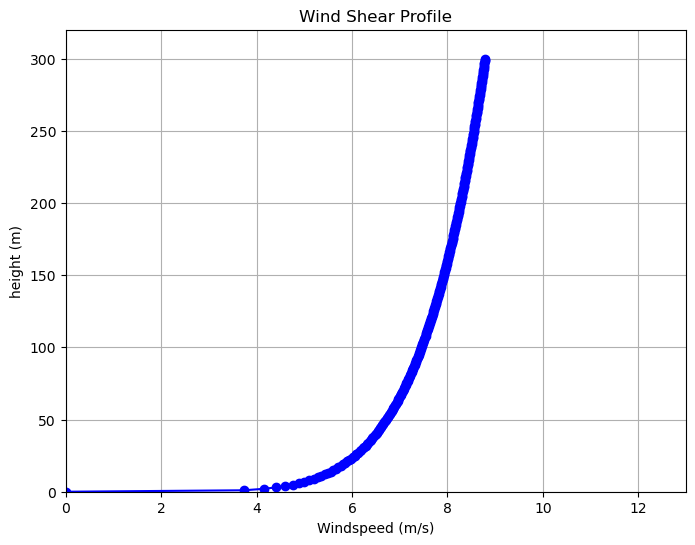

In [207]:
# find the wind speed at hub height of 175 m
alpha = 0.15
V_hub = V_10 * ((z_hub/z_10)**alpha)

# consider a number of vertical coordinates, that you want to plot using a mean wind speed
V_10 = pdData.dwd_ws.mean()
z = np.linspace(0, 300, 301)
V = V_10 * ((z/z_10)**alpha)

# Create the wind shear profile plot
plt.figure(figsize=(8, 6))
plt.plot(V, z, marker='o', linestyle='-', color='b')
plt.xlabel('Windspeed (m/s)')
plt.ylabel('height (m)')
plt.title('Wind Shear Profile')
plt.axis([0,13, 0, 320])
plt.grid(True)
plt.show()

Here we calculate the kinetic energy flux in the wind at this site. This is the amount of energy in the wind and does not include the losses

In [262]:
# Area of the rotor [m^2]
D = 200  # rotor diameter
A_rotor = (np.pi/4) * D**2 
rho = 1.225 # air density [kg/m^3]

# wind speed at hub height
z_hub = 175 # hub height of the wind turbine
# find the kinteic energy at the test location
P_ke = np.sum(0.5 * rho * A_rotor * (V_hub**3))
print(f"Kinetic energy at the testsite for this turbine for this time period (year): {P_ke/(6*1e6)} MWh") 


Kinetic energy at the testsite for this turbine for this time period (year): 177143.32759834317 MW


Let us import a power curve from a reference turbine. We use NREL's 7 MW wind turbine with a rotor diameter of 200 m. More information on https://nrel.github.io/turbine-models/2020ATB_NREL_Reference_7MW_200.html

In [209]:
df_wt = pd.read_csv(r"2020ATB_NREL_Reference_7MW_200.csv")
print(df_wt)

    Wind Speed [m/s]  Power [kW]    Cp [-]
0               3.00           0  0.000000
1               3.25         168  0.254333
2               3.50         235  0.284844
3               3.75         312  0.307471
4               4.00         400  0.324806
..               ...         ...       ...
84             24.00        7000  0.026315
85             24.25        7000  0.025510
86             24.50        7000  0.024737
87             24.75        7000  0.023995
88             25.00           0  0.000000

[89 rows x 3 columns]


The power coefficient is the efficiency factor with which the energy from the wind can be captured.

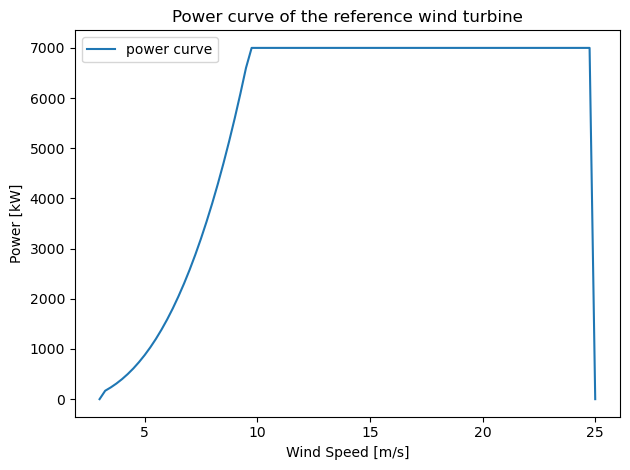

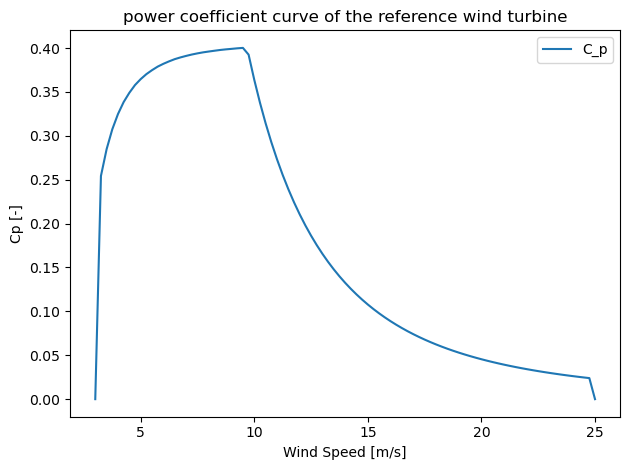

In [210]:
# power curve of NREL reference turbine
plt.plot(df_wt['Wind Speed [m/s]'], df_wt['Power [kW]'], label='power curve')
plt.xlabel('Wind Speed [m/s]')
plt.ylabel('Power [kW]')
plt.title("Power curve of the reference wind turbine")
plt.legend()
plt.tight_layout()
plt.show()

# Power coefficient for Krogmann WEA
plt.plot(df_wt['Wind Speed [m/s]'], df_wt['Cp [-]'], label='C_p')
plt.xlabel('Wind Speed [m/s]')
plt.ylabel('Cp [-]')
plt.title("power coefficient curve of the reference wind turbine")
plt.legend()
plt.tight_layout()
plt.show()


For the calculation of AEP as shown on slide 33, we need three input parameters, the number of hours Nh, a distribution of wind speed at the test location and a distribution of power with respect to wind speed. For the distribution of wind speed, we can simply use a special case of Rayleigh distribution namely the Weibull distribution. 

Text(0, 0.5, 'Counts')

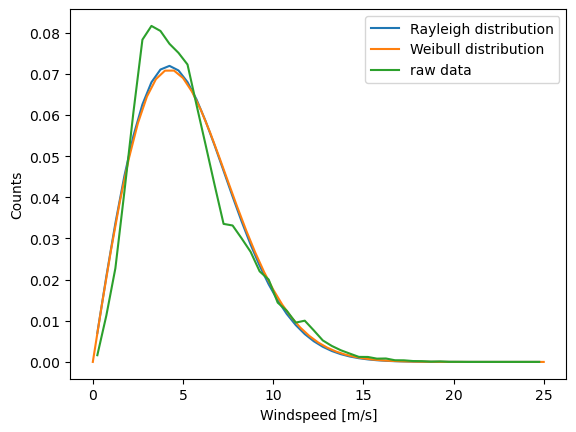

In [264]:
k = k_out
A = A_out
V = np.linspace(0,25,51)

# Rayleigh distribution
V_ave = V_10.mean()
FV_rayleigh_cdf = 1 - np.exp(-(np.pi/4) * (V/V_ave)**2)
FV_rayleigh_pdf = np.diff(FV_rayleigh_cdf)
plt.plot(bin_center, FV_rayleigh_pdf, label='Rayleigh distribution')
# fitted Weibull parameters
FV_fitted = (k/A) * (V/A)**(k-1) * np.exp(-(V/A)**k) * 0.5
plt.plot(bins, FV_fitted, label='Weibull distribution')
# # original data
plt.plot(bin_center, vals/np.sum(vals), label='raw data')
plt.legend(loc='best')
plt.xlabel("Windspeed [m/s]")
plt.ylabel("Counts")

In [213]:
df_wt

,Wind Speed [m/s],Power [kW],Cp [-]
0,3.00,0,0.000000
1,3.25,168,0.254333
2,3.50,235,0.284844
3,3.75,312,0.307471
4,4.00,400,0.324806
...,...,...,...
84,24.00,7000,0.026315
85,24.25,7000,0.025510
86,24.50,7000,0.024737
87,24.75,7000,0.023995


We first need to interpolate the Power curve (with a bin width of 0.25 m/s) of the wind turbine, so that the bins of 0.5 m/s are satisfied.

In [266]:
Nh = 8760
# interpolate the power curve to match a bin width of 0.5 m/s
Pi = np.interp(bins, df_wt['Wind Speed [m/s]'], df_wt['Power [kW]'], left=0, right=df_wt['Power [kW]'].max())
# gross Annual energy production 
P_aep = Nh * np.sum(abs(np.diff(vals/np.sum(vals), prepend=0)) * ((Pi[:-1] + Pi[1:])/2)) * 1e-3
print(f"Annual gross energy production: {P_aep} MWh")

# Consider a capacity factor of 0.3 (The turbine is running at about 70% efficiency)
C_f = 0.3
P_aep_net = P_aep * (1-C_f)
print(f"Annual net energy production: {P_aep_net} MWh")

Annual gross energy production: 2718.7661594934743 MWh
Annual net energy production: 1903.136311645432 MWh


Calculate the exceedence probabilities for wind energy

In [267]:
# exceedence probabilities
from scipy.stats import norm

# consider an uncertainty in the wind estimations to be 11 %
uncertainty_aep = 11

P_aep_p50 = P_aep_net
P_aep_std = P_aep_p50 * uncertainty_aep / 100
prob = np.linspace(0.01, 0.99, 99) 
aep_prob = norm.ppf( (1 - prob), loc =P_aep_p50 , scale=P_aep_std)

# calculate the p75 value
P_aep_p75 = P_aep_p50  - 0.675 * P_aep_std

# calculate the P990 value. This value is important for financing projects
P_aep_p90 = P_aep_p50  - 1.282 * P_aep_std

The P50 value is the mean and the uncertainty contributes to the standard deviation. The plot below explains where the P50 lies and where the P90 value lies. The OEMs or wind park developers promise this value to be fulfilled.

Text(0.5, 0, 'AEP [MWh/year]')

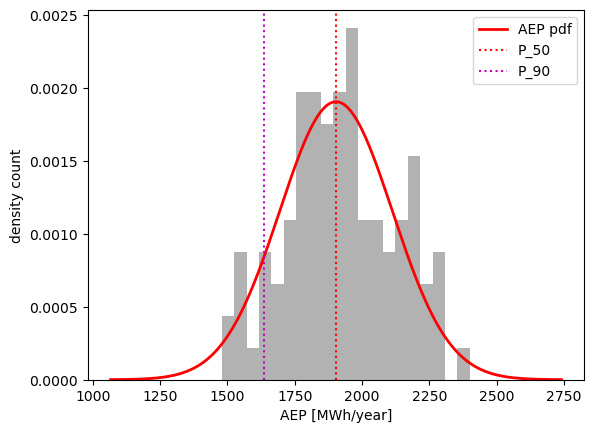

In [219]:
# we create a distribution out of P50 and sigma values
results = norm.rvs(P_aep_p50, P_aep_std, len(prob))
plt.hist(results, bins=20, density=True, alpha=0.6, color='gray')

# Plot the probability density function
x = np.linspace(P_aep_p50 - 4 * P_aep_std, P_aep_p50 + 4 * P_aep_std, 1000)
pdf = 1 / (P_aep_std * np.sqrt(2 * np.pi)) * np.exp(-0.5 * ((x - P_aep_p50) / P_aep_std) ** 2)
plt.plot(x, pdf, 'r', lw=2, label='AEP pdf')
plt.axvline(x=P_aep_p50,c='r', linestyle=":", label="P_50")
plt.axvline(x=P_aep_p90,c='m', linestyle=":", label="P_90")
plt.legend(loc='best')
plt.ylabel("density count")
plt.xlabel("AEP [MWh/year]")